# Load and Save sample Scan

In [115]:
import os
import numpy as np
import pandas as pd
import pydicom
import ast  # For safe conversion of stringified lists

# Define default metadata values (used when metadata is missing)
DEFAULT_METADATA = {
    "slice_thickness": 2.5,  # mm
    "slice_spacing": 2.5,    # mm
    "pixel_spacing": (0.7, 0.7),  # Ensure tuple of length 2
    "origin": (0.0, 0.0, 0.0),  # Default world coordinates
    "orientation": (1.0, 0.0, 0.0, 0.0, 1.0, 0.0),  # Ensure tuple of length 6
    "rescale_intercept": -1024.0,  # Standard air HU value
    "rescale_slope": 1.0,  # Default scaling factor
    "contrast_used": False
}

def parse_list(value, expected_length=None):
    """
    Parses a string representation of a list into a tuple of floats.
    If an expected length is provided, ensures the tuple has the correct length.
    """
    try:
        if isinstance(value, str):
            parsed = tuple(map(float, ast.literal_eval(value)))
        elif isinstance(value, (list, tuple, np.ndarray)):
            parsed = tuple(map(float, value))
        else:
            parsed = (float(value),)

        if expected_length and len(parsed) != expected_length:
            print(f"Warning: Expected length {expected_length}, got {len(parsed)}. Using default.")
            return DEFAULT_METADATA["orientation"] if expected_length == 6 else DEFAULT_METADATA["pixel_spacing"]

        return parsed
    except:
        print(f"Error parsing value: {value}. Using default.")
        return DEFAULT_METADATA["orientation"] if expected_length == 6 else DEFAULT_METADATA["pixel_spacing"]

def load_metadata(csv_path, patient_id):
    """
    Load metadata for a given PatientID from the CSV file.
    Uses default metadata if the PatientID is not found or the CSV is missing.

    Parameters:
        csv_path (str): Path to the metadata CSV file.
        patient_id (str): Patient ID to search for (e.g., 'LIDC-IDRI-0001').

    Returns:
        metadata (dict): Dictionary containing metadata and transform matrix.
    """
    if not os.path.exists(csv_path):
        print(f"Warning: Metadata CSV file '{csv_path}' not found. Using default metadata.")
        return DEFAULT_METADATA

    df = pd.read_csv(csv_path)

    # Filter rows matching the PatientID
    patient_metadata = df[df["PatientID"] == patient_id]
    
    if patient_metadata.empty:
        print(f"Warning: Metadata not found for PatientID '{patient_id}'. Using default metadata.")
        return DEFAULT_METADATA

    # Take the first matching row
    meta = patient_metadata.iloc[0]

    # Parse values from CSV (or use defaults if missing)
    slice_thickness = float(meta.get("SliceThickness", DEFAULT_METADATA["slice_thickness"]))
    slice_spacing = float(meta.get("SliceSpacing", DEFAULT_METADATA["slice_spacing"]))
    pixel_spacing = parse_list(meta.get("PixelSpacing", DEFAULT_METADATA["pixel_spacing"]), expected_length=2)
    origin = parse_list(meta.get("ImagePositionPatient", DEFAULT_METADATA["origin"]), expected_length=3)
    orientation = parse_list(meta.get("ImageOrientationPatient", DEFAULT_METADATA["orientation"]), expected_length=6)
    rescale_intercept = float(meta.get("RescaleIntercept", DEFAULT_METADATA["rescale_intercept"]))
    rescale_slope = float(meta.get("RescaleSlope", DEFAULT_METADATA["rescale_slope"]))
    contrast_used = bool(meta.get("ContrastUsed", DEFAULT_METADATA["contrast_used"]))

    # Compute the transformation matrix
    transform_matrix = compute_transform_matrix(origin, orientation, pixel_spacing, slice_spacing)

    metadata = {
        "slice_thickness": slice_thickness,
        "slice_spacing": slice_spacing,
        "pixel_spacing": pixel_spacing,
        "origin": origin,
        "orientation": orientation,
        "rescale_intercept": rescale_intercept,
        "rescale_slope": rescale_slope,
        "transform_matrix": transform_matrix,
        "contrast_used": contrast_used
    }

    return metadata

def compute_transform_matrix(origin, orientation, pixel_spacing, slice_spacing):
    """
    Computes the 4x4 affine transformation matrix from voxel indices to patient coordinates.
    
    Parameters:
        origin (tuple): Patient coordinate of the first pixel (ImagePositionPatient)
        orientation (tuple): 6 numbers representing row and column direction cosines.
        pixel_spacing (tuple): (spacing_x, spacing_y) in mm.
        slice_spacing (float): Distance between slices in mm.
        
    Returns:
        A 4x4 numpy array representing the affine transform.
    """
    row_cosines = np.array(orientation[0:3])
    col_cosines = np.array(orientation[3:6])
    normal = np.cross(row_cosines, col_cosines)

    T = np.eye(4)
    T[0, :3] = pixel_spacing[0] * row_cosines
    T[1, :3] = pixel_spacing[1] * col_cosines
    T[2, :3] = slice_spacing * normal
    T[:3, 3] = origin

    return T

def load_scan(dicom_dir):
    """
    Load all DICOM files from a directory and sort them by their slice location.
    
    Parameters:
        dicom_dir (str): Path to the directory containing DICOM files.

    Returns:
        List of sorted pydicom FileDataset objects.
    """
    slices = [pydicom.dcmread(os.path.join(dicom_dir, f))
              for f in os.listdir(dicom_dir) if f.endswith(".dcm")]
    slices = [s for s in slices if hasattr(s, "ImagePositionPatient")]
    slices.sort(key=lambda s: float(s.ImagePositionPatient[2]))
    return slices

def convert_to_hu(slices, rescale_intercept, rescale_slope):
    """
    Convert the raw DICOM pixel data to Hounsfield Units (HU).

    Parameters:
        slices (list): Sorted DICOM slices.
        rescale_intercept (float): Value to add.
        rescale_slope (float): Value to multiply.

    Returns:
        A 3D numpy array representing the CT volume in HU.
    """
    image = np.stack([s.pixel_array for s in slices], axis=0).astype(np.int16)

    if rescale_slope != 1:
        image = rescale_slope * image.astype(np.float32)
        image = image.astype(np.int16)
    image += np.int16(rescale_intercept)

    return image

def save_npy(output_dir, hu_volume, metadata):
    """
    Save the HU volume and metadata to .npy files.

    Parameters:
        output_dir (str): Directory where output files will be saved.
        hu_volume (numpy array): The 3D CT volume in HU.
        metadata (dict): Dictionary of spatial metadata.
    """
    os.makedirs(output_dir, exist_ok=True)
    npy_path = os.path.join(output_dir, "ct_scan_hu.npy")
    meta_path = os.path.join(output_dir, "metadata.npy")

    np.save(npy_path, hu_volume)
    np.save(meta_path, metadata)

    print(f"Saved CT scan (HU) at: {npy_path}")
    print(f"Saved metadata at: {meta_path}")

# ==== EDIT THESE PATHS ====
dicom_folder = "../cache/1546"  # Folder containing DICOM files for the scan
output_folder = "../cache/1546_processed"  # Where to save the processed outputs
csv_path = "../cache/scans_meta.csv"  # Path to the metadata CSV file

# Derive PatientID from the folder name
scan_id = os.path.basename(dicom_folder)
patient_id = f"LIDC-IDRI-{scan_id[-4:]}"  # e.g., 'LIDC-IDRI-0001'

# Load metadata from CSV or use defaults
metadata = load_metadata(csv_path, patient_id)

# Debug: Print metadata to check if defaults are used
print(f"Using Metadata for PatientID {patient_id}: {metadata}")

# Load and process CT scan
slices = load_scan(dicom_folder)
hu_volume = convert_to_hu(slices, metadata["rescale_intercept"], metadata["rescale_slope"])

# Save as npy files
save_npy(output_folder, hu_volume, metadata)

Using Metadata for PatientID LIDC-IDRI-1546: {'slice_thickness': 2.5, 'slice_spacing': 2.5, 'pixel_spacing': (0.7, 0.7), 'origin': (0.0, 0.0, 0.0), 'orientation': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0), 'rescale_intercept': -1024.0, 'rescale_slope': 1.0, 'contrast_used': False}
Saved CT scan (HU) at: ../cache/1546_processed/ct_scan_hu.npy
Saved metadata at: ../cache/1546_processed/metadata.npy


# Display Extracted Cube

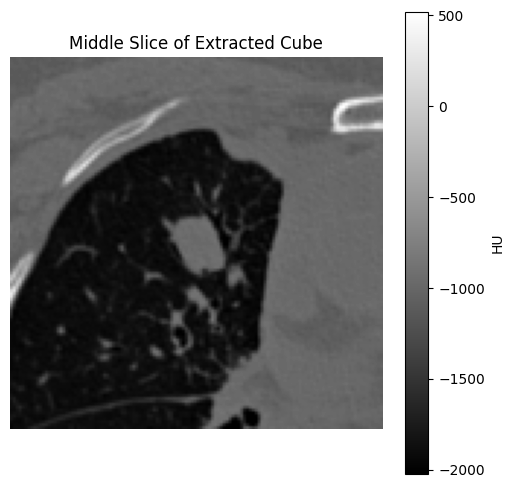

In [120]:
import numpy as np
import matplotlib.pyplot as plt

def extract_cube(ct_scan, center, cube_size=(128, 128, 128)):
    """
    Extracts a cube of given size from a 3D CT scan centered at a specified location.

    Parameters:
        ct_scan (numpy array): The 3D CT scan in HU.
        center (tuple): (z, y, x) coordinates of the cube center.
        cube_size (tuple): (depth, height, width) of the cube.

    Returns:
        numpy array: Extracted cube.
    """
    z, y, x = center
    d, h, w = cube_size

    # Compute boundaries
    z_min, z_max = max(0, z - d // 2), min(ct_scan.shape[0], z + d // 2)
    y_min, y_max = max(0, y - h // 2), min(ct_scan.shape[1], y + h // 2)
    x_min, x_max = max(0, x - w // 2), min(ct_scan.shape[2], x + w // 2)

    # Extract the cube
    cube = ct_scan[z_min:z_max, y_min:y_max, x_min:x_max]

    # Ensure cube size consistency by padding if necessary
    pad_z = (d - cube.shape[0]) // 2
    pad_y = (h - cube.shape[1]) // 2
    pad_x = (w - cube.shape[2]) // 2

    cube = np.pad(cube, ((pad_z, d - cube.shape[0] - pad_z),
                          (pad_y, h - cube.shape[1] - pad_y),
                          (pad_x, w - cube.shape[2] - pad_x)),
                  mode='constant', constant_values=-1000)  # Pad with air HU value (-1000)

    return cube

def display_middle_slice(cube):
    """
    Displays the middle slice of the extracted cube.

    Parameters:
        cube (numpy array): Extracted 3D cube.
    """
    middle_slice = cube[cube.shape[0] // 2]  # Take the middle slice along Z-axis

    plt.figure(figsize=(6, 6))
    plt.imshow(middle_slice, cmap='gray')
    plt.colorbar(label="HU")
    plt.title("Middle Slice of Extracted Cube")
    plt.axis("off")
    plt.show()

# ==== EDIT THESE PATHS ====
ct_scan_path = "../cache/1546_processed/ct_scan_hu.npy"  # Path to saved CT scan .npy
center = (159, 243,183 )  # (z, y, x) location to extract cube from

# Load the CT scan
ct_scan = np.load(ct_scan_path)

# Extract cube
cube = extract_cube(ct_scan, center)

# Display middle slice
display_middle_slice(cube)

# MagicWand Tool

/var/folders/b2/tcx56zz51t5brx0bkp2b2qc80000gn/T/ipykernel_21166/3504559500.py:4: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom
/var/folders/b2/tcx56zz51t5brx0bkp2b2qc80000gn/T/ipykernel_21166/3504559500.py:5: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_fill_holes


Processing slices 154 to 164 (inclusive).
Saved cancer nodule mask at: ../cache/1546_processed/cancer_nodule_mask.npy


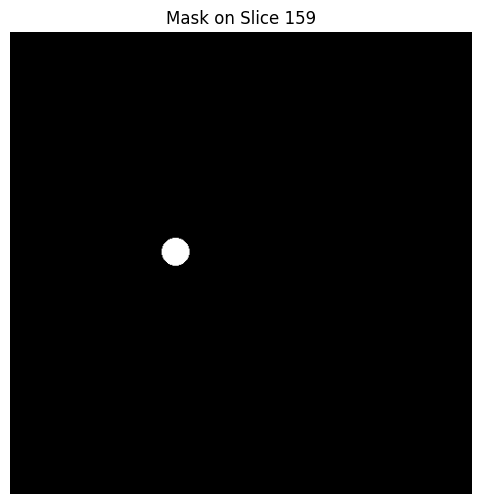

In [125]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.morphology import binary_fill_holes

# ============================
# Magic Wand Implementation
# ============================

def coord_polar_to_cart(r, theta, center):
    '''Converts polar coordinates around center to Cartesian'''
    x = r * np.cos(theta) + center[0]
    y = r * np.sin(theta) + center[1]
    return x, y

def coord_cart_to_polar(x, y, center):
    '''Converts Cartesian coordinates to polar'''
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    theta = np.arctan2((y - center[1]), (x - center[0]))
    return r, theta

def image_cart_to_polar(image, center, min_radius, max_radius, phase_width, zoom_factor=1):
    '''Converts an image from cartesian to polar coordinates around center'''

    if zoom_factor != 1:
        image = zoom(image, (zoom_factor, zoom_factor), order=4)
        center = (center[0]*zoom_factor + zoom_factor/2, center[1]*zoom_factor + zoom_factor/2)
        min_radius = min_radius * zoom_factor
        max_radius = max_radius * zoom_factor
    
    # Pad if necessary
    max_x, max_y = image.shape
    pad_dist_x = np.max([(center[0] + max_radius) - max_x, -(center[0] - max_radius)])
    pad_dist_y = np.max([(center[1] + max_radius) - max_y, -(center[1] - max_radius)])
    pad_dist = int(np.max([0, pad_dist_x, pad_dist_y]))
    if pad_dist != 0:
        image = np.pad(image, pad_dist, mode='constant')

    # Create polar coordinate grid
    theta, r = np.meshgrid(np.linspace(0, 2*np.pi, phase_width),
                           np.arange(min_radius, max_radius))
    x, y = coord_polar_to_cart(r, theta, center)
    x, y = np.round(x).astype(int), np.round(y).astype(int)

    polar = image[x, y]
    polar.reshape((max_radius - min_radius, phase_width))
    return polar

def mask_polar_to_cart(mask, center, min_radius, max_radius, output_shape, zoom_factor=1):
    '''Converts a polar binary mask back to Cartesian and places it in an image of zeros.'''
    if zoom_factor != 1:
        center = (center[0]*zoom_factor + zoom_factor/2, center[1]*zoom_factor + zoom_factor/2)
        min_radius = min_radius * zoom_factor
        max_radius = max_radius * zoom_factor
        output_shape = tuple([int(a * zoom_factor) for a in output_shape])
    
    image = np.zeros(output_shape, dtype=float)

    theta, r = np.meshgrid(np.linspace(0, 2*np.pi, mask.shape[1]),
                           np.arange(0, max_radius))
    x, y = coord_polar_to_cart(r, theta, center)
    x, y = np.round(x).astype(int), np.round(y).astype(int)
    x = np.clip(x, 0, image.shape[0]-1)
    y = np.clip(y, 0, image.shape[1]-1)

    image[x, y] = mask

    if zoom_factor != 1:
        zf = 1/float(zoom_factor)
        image = zoom(image, (zf, zf), order=4)

    image = (image > 0.5).astype(int)  # Force binary
    image = binary_fill_holes(image)
    return image

def find_edge_2d(polar, min_radius):
    '''Dynamic programming algorithm to find edge given polar image'''
    if polar.ndim != 2:
        raise ValueError("argument to find_edge_2d must be 2D")
    
    # Shifted versions for dynamic programming
    values_right_shift      = np.pad(polar, ((0, 0), (0, 1)), mode='constant')[:, 1:]
    values_closeright_shift = np.pad(polar, ((1, 0), (0, 1)), mode='constant')[:-1, 1:]
    values_awayright_shift  = np.pad(polar, ((0, 1), (0, 1)), mode='constant')[1:, 1:]

    # Combine possible moves: away-right, right, closeright
    values_move = np.zeros((polar.shape[0], polar.shape[1], 3))
    values_move[:, :, 0] = polar + values_awayright_shift
    values_move[:, :, 1] = polar + values_right_shift
    values_move[:, :, 2] = polar + values_closeright_shift

    values = values_move.max(axis=2)
    directions = np.argmax(values_move, axis=2)
    directions = directions - 1
    directions = -directions

    # Edge following
    edge = []
    mask = np.zeros(polar.shape, dtype=int)
    
    r_max = 0
    r = 0
    for i, v in enumerate(values[:, 0]):
        if v >= r_max:
            r, r_max = i, v
    edge.append((r + min_radius, 0))
    mask[0:r+1, 0] = 1

    for t in range(1, polar.shape[1]):
        r += directions[r, t-1]
        r = max(0, min(r, directions.shape[0]-1))
        edge.append((r + min_radius, t))
        mask[0:r+1, t] = 1

    # Add inside for min_radius offset
    new_mask = np.ones((min_radius + mask.shape[0], mask.shape[1]), dtype=int)
    new_mask[min_radius:, :] = mask
    return np.array(edge), new_mask

def edge_polar_to_cart(edge, center):
    '''Converts a list of polar edge points to a list of cartesian edge points'''
    cart_edge = []
    for (r, t) in edge:
        x, y = coord_polar_to_cart(r, t, center)
        cart_edge.append((round(x), round(y)))
    return cart_edge

def cell_magic_wand_single_point(image, center, min_radius, max_radius,
                                 roughness=2, zoom_factor=1):
    '''Wand tool for a single center point.'''
    if roughness < 1:
        roughness = 1
    if min_radius < 0:
        min_radius = 0
    if max_radius <= min_radius:
        max_radius = min_radius + 1
    if zoom_factor <= 0:
        zoom_factor = 1
    
    phase_width = int(2 * np.pi * max_radius * roughness)
    polar_image = image_cart_to_polar(image, center, min_radius, max_radius,
                                      phase_width=phase_width, zoom_factor=zoom_factor)
    polar_edge, polar_mask = find_edge_2d(polar_image, min_radius)
    cart_edge = edge_polar_to_cart(polar_edge, center)
    cart_mask = mask_polar_to_cart(polar_mask, center, min_radius, max_radius,
                                   image.shape, zoom_factor=zoom_factor)
    return cart_mask, cart_edge

def cell_magic_wand(image, center, min_radius, max_radius,
                    roughness=2, zoom_factor=1, center_range=2):
    '''Runs wand tool on multiple perturbed seed points for robust segmentation.'''
    centers = []
    for i in [-center_range, 0, center_range]:
        for j in [-center_range, 0, center_range]:
            centers.append((center[0] + i, center[1] + j))
    
    masks = np.zeros((image.shape[0], image.shape[1], len(centers)), dtype=float)
    for idx, c in enumerate(centers):
        mask_2d, edge = cell_magic_wand_single_point(
            image, c, min_radius, max_radius,
            roughness=roughness, zoom_factor=zoom_factor
        )
        masks[..., idx] = mask_2d
    
    mean_mask = np.mean(masks, axis=2)
    final_mask = (mean_mask > 0.5).astype(np.uint8)
    return final_mask

# ============================
# 3D Cancer Nodule Mask Extraction
# ============================

def create_3d_cancer_mask(ct_volume, seed_slice, seed_point, min_radius, max_radius,
                          roughness=2, zoom_factor=1, center_range=2, slices_above_below=5):
    """
    Creates a 3D binary mask for a cancer nodule within a CT scan.

    For the seed slice (where the cancer center is known) plus slices above/below,
    runs the Magic Wand segmentation. The resulting 2D masks are placed into a 3D volume.
    """
    num_slices, height, width = ct_volume.shape
    mask_volume = np.zeros_like(ct_volume, dtype=np.uint8)
    
    # Determine slice range
    start_slice = max(0, seed_slice - slices_above_below)
    end_slice = min(num_slices, seed_slice + slices_above_below + 1)
    print(f"Processing slices {start_slice} to {end_slice - 1} (inclusive).")
    
    for s in range(start_slice, end_slice):
        slice_img = ct_volume[s]
        # Segment this 2D slice
        mask_2d = cell_magic_wand(
            slice_img, seed_point, min_radius, max_radius,
            roughness=roughness, zoom_factor=zoom_factor, center_range=center_range
        )
        # Insert into 3D volume
        mask_volume[s] = mask_2d.astype(np.uint8)
    
    # Force final mask strictly 0 or 1
    mask_volume = (mask_volume > 0).astype(np.uint8)

    # Optional: Check if the final mask is uniform (all 0 or all 1)
    mask_min, mask_max = mask_volume.min(), mask_volume.max()
    if mask_min == mask_max:
        print("WARNING: Final 3D mask is uniform. Possibly no region was segmented or entire volume is segmented.")

    return mask_volume

def display_mask_slice(mask_volume, slice_index):
    """Display one slice of the 3D mask."""
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_volume[slice_index], cmap='gray')
    plt.title(f"Mask on Slice {slice_index}")
    plt.axis("off")
    plt.show()

# ============================
# Main Execution
# ============================

if __name__ == "__main__":
    # ---- Editable parameters ----
    seed_slice = 159             # Central slice index for the cancer patch
    seed_point = (243, 183)      # (row, column) or (y,x) nodule center in the seed slice
    min_radius = 15              # Minimum radius for wand segmentation
    max_radius = 20              # Maximum radius
    roughness = 2                # Controls polar transform resolution
    zoom_factor = 1              # Upsampling factor
    center_range = 2             # Perturbation range for robust segmentation
    slices_above_below = 5       # Number of slices above/below seed slice
    
    # ---- Paths (edit as needed) ----
    ct_scan_path = "../cache/1546_processed/ct_scan_hu.npy"
    mask_output_path = "../cache/1546_processed/cancer_nodule_mask.npy"
    
    # 1. Load the 3D CT volume (HU)
    ct_volume = np.load(ct_scan_path)
    
    # 2. Create the 3D nodule mask via magic wand
    cancer_mask = create_3d_cancer_mask(
        ct_volume, seed_slice, seed_point,
        min_radius, max_radius,
        roughness, zoom_factor, center_range, slices_above_below
    )
    
    # 3. Save the resulting 3D mask
    np.save(mask_output_path, cancer_mask)
    print(f"Saved cancer nodule mask at: {mask_output_path}")
    
    # 4. Display the seed slice to verify
    display_mask_slice(cancer_mask, seed_slice)

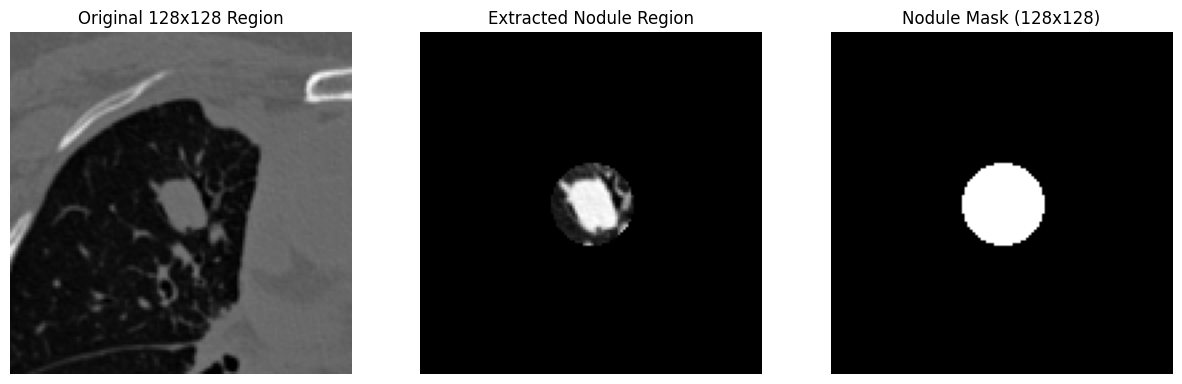

In [129]:
import os
import numpy as np
import matplotlib.pyplot as plt

def find_nodule_center(mask_volume):
    """
    Finds the center of the masked nodule region in 3D.

    Parameters:
        mask_volume (np.array): 3D binary mask (same shape as CT scan).

    Returns:
        tuple: (z_center, y_center, x_center) coordinates of the nodule center.
    """
    coords = np.argwhere(mask_volume > 0)  # Find nonzero indices (z, y, x)
    
    if len(coords) == 0:
        raise ValueError("No nodule found in mask. Ensure the mask is correctly generated.")

    z_center, y_center, x_center = np.mean(coords, axis=0).astype(int)
    return z_center, y_center, x_center

def extract_128x128_region(ct_volume, mask_volume):
    """
    Extracts a 128x128 region centered around the nodule in the middle slice.

    Parameters:
        ct_volume (np.array): The full 3D CT scan.
        mask_volume (np.array): The 3D mask showing the nodule locations.

    Returns:
        tuple: Cropped (128x128) original CT scan, extracted nodule region, and corresponding mask.
    """
    # Find the nodule center
    z_center, y_center, x_center = find_nodule_center(mask_volume)

    # Define cropping bounds (ensure they remain within the image dimensions)
    half_size = 64  # 128x128 plane → half is 64 pixels
    y_min, y_max = max(0, y_center - half_size), min(ct_volume.shape[1], y_center + half_size)
    x_min, x_max = max(0, x_center - half_size), min(ct_volume.shape[2], x_center + half_size)

    # Crop the regions
    cropped_original = ct_volume[z_center, y_min:y_max, x_min:x_max]
    cropped_extracted = np.where(mask_volume[z_center, y_min:y_max, x_min:x_max] > 0,
                                 ct_volume[z_center, y_min:y_max, x_min:x_max], np.min(ct_volume))
    cropped_mask = mask_volume[z_center, y_min:y_max, x_min:x_max]

    return cropped_original, cropped_extracted, cropped_mask

def display_128x128_region(original, extracted, mask):
    """
    Displays the 128x128 extracted region from the original scan, extracted nodule, and mask.

    Parameters:
        original (np.array): Cropped 128x128 region from the original CT scan.
        extracted (np.array): Cropped 128x128 extracted nodule region.
        mask (np.array): Cropped 128x128 mask.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original 128x128 Region")
    axes[0].axis("off")

    axes[1].imshow(extracted, cmap='gray')
    axes[1].set_title("Extracted Nodule Region")
    axes[1].axis("off")

    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title("Nodule Mask (128x128)")
    axes[2].axis("off")

    plt.show()

if __name__ == "__main__":
    # ==== EDIT THESE PATHS ====
    ct_scan_path = "../cache/1546_processed/ct_scan_hu.npy"        # Path to the processed CT scan
    mask_path = "../cache/1546_processed/cancer_nodule_mask.npy"  # Path to the cancer nodule mask

    # Load CT scan and mask
    ct_volume = np.load(ct_scan_path)
    mask_volume = np.load(mask_path)

    # Extract the 128x128 region
    cropped_original, cropped_extracted, cropped_mask = extract_128x128_region(ct_volume, mask_volume)

    # Display the cropped region
    display_128x128_region(cropped_original, cropped_extracted, cropped_mask)

# Perform Nodule Extraction in the mask

Loaded CT volume with shape: (275, 512, 512)
Loaded mask with shape: (275, 512, 512)
No connected components found.
Isolated largest component saved at: ../cache/1546_processed/isolated_cancer.npy


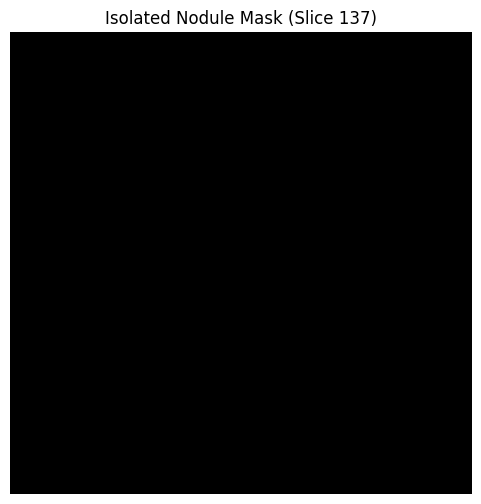

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

def load_data(ct_scan_path, mask_path):
    """
    Load the CT scan (HU) and cancer nodule mask from .npy files.
    """
    ct_volume = np.load(ct_scan_path)
    mask_volume = np.load(mask_path)
    return ct_volume, mask_volume

def isolate_roi(ct_volume, mask_volume):
    """
    Use the mask to extract the region of interest (ROI) from the CT volume.
    
    Returns:
        roi (np.array): CT values within the mask (zero outside).
    """
    roi = ct_volume * (mask_volume > 0)
    return roi

def threshold_roi(roi, mask_volume, threshold_value=-500):
    """
    Apply a threshold to the ROI extracted from the CT volume. The threshold
    is applied only within the masked region.
    
    Parameters:
        roi (np.array): Region of interest from the CT volume.
        mask_volume (np.array): The original mask (nonzero where ROI is).
        threshold_value (int/float): HU threshold to isolate tissue (e.g., -500 HU).
    
    Returns:
        binary_roi (np.array): Binary image where voxels in the masked region 
                                 and above the threshold are 1, else 0.
    """
    # Within the mask, check if CT value > threshold_value
    binary_roi = ((roi > threshold_value) & (mask_volume > 0)).astype(np.uint8)
    return binary_roi

def isolate_largest_component(binary_image):
    """
    Given a binary image (3D mask), perform connected-component labeling and
    isolate only the largest component.
    
    Returns:
        isolated (np.array): Binary mask containing only the largest component.
    """
    # Label connected components (for 3D, default connectivity is 26)
    labeled = label(binary_image)
    if labeled.max() == 0:
        print("No connected components found.")
        return binary_image
    # Identify the largest component by voxel count
    regions = regionprops(labeled)
    largest_region = max(regions, key=lambda r: r.area)
    isolated = (labeled == largest_region.label).astype(np.uint8)
    return isolated

def main():
    # ---- Paths (edit as needed) ----
    ct_scan_path = "../cache/1546_processed/ct_scan_hu.npy"
    mask_path    = "../cache/1546_processed/cancer_nodule_mask.npy"
    output_path  = "../cache/1546_processed/isolated_cancer.npy"
    
    # ---- Parameters ----
    # Adjust the threshold value (HU) as appropriate for your nodule segmentation.
    threshold_value = -500
    
    # 1. Load the full CT volume and the original mask
    ct_volume, mask_volume = load_data(ct_scan_path, mask_path)
    print(f"Loaded CT volume with shape: {ct_volume.shape}")
    print(f"Loaded mask with shape: {mask_volume.shape}")
    
    # 2. Use the mask to extract the region of interest from the CT volume
    roi = isolate_roi(ct_volume, mask_volume)
    
    # 3. Apply thresholding to the ROI (only inside the masked region)
    binary_roi = threshold_roi(roi, mask_volume, threshold_value=threshold_value)
    
    # 4. Apply connected component analysis on the thresholded ROI
    isolated_mask = isolate_largest_component(binary_roi)
    
    # 5. Save the isolated component mask
    np.save(output_path, isolated_mask)
    print(f"Isolated largest component saved at: {output_path}")
    
    # 6. For display, show the central slice of the isolated mask.
    # Here we choose the center slice of the isolated mask along the z-axis.
    center_slice = isolated_mask.shape[0] // 2
    plt.figure(figsize=(6, 6))
    plt.imshow(isolated_mask[center_slice], cmap='gray')
    plt.title(f"Isolated Nodule Mask (Slice {center_slice})")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()


## ASRG nodule isolation

CT volume shape: (481, 512, 512)
ROI mask shape: (481, 512, 512)
Region growing seed point: (295, 312, 163)
Extracted binary region mask saved at: ../cache/1003_processed/isolated_ASRG_cancer.npy


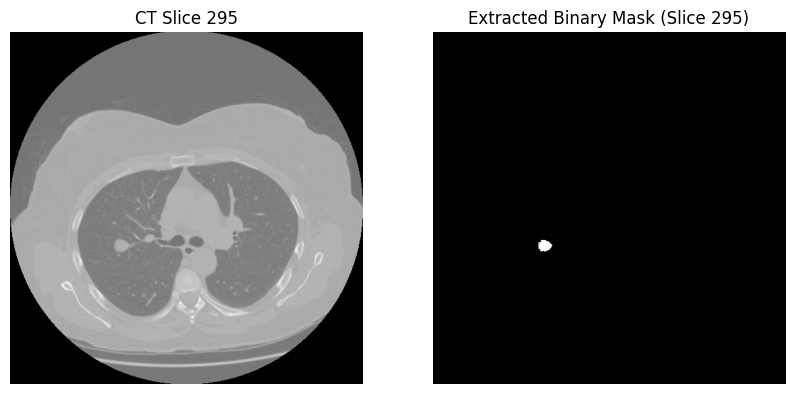

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def load_data(ct_scan_path, mask_path):
    """
    Load the CT scan (HU) and ROI mask from .npy files.
    """
    ct_volume = np.load(ct_scan_path)
    roi_mask = np.load(mask_path)
    return ct_volume, roi_mask

def get_seed_point(roi_mask):
    """
    Automatically determine a seed point from the ROI mask.
    Computes the centroid of all nonzero voxels.
    
    Returns:
        seed (tuple): (z, y, x) coordinates of the seed.
    """
    coords = np.argwhere(roi_mask > 0)
    if coords.size == 0:
        raise ValueError("ROI mask is empty. Cannot determine seed point.")
    centroid = np.mean(coords, axis=0)
    seed = tuple(np.round(centroid).astype(int))
    return seed

def region_growing(ct_volume, roi_mask, seed, threshold=50):
    """
    Perform region growing within the ROI defined by roi_mask on the CT volume.
    
    Voxels are added if:
      - They are within the ROI mask.
      - Their intensity difference from the seed intensity is <= threshold.
    
    Parameters:
        ct_volume (np.array): 3D CT scan (HU).
        roi_mask (np.array): Binary ROI mask (nonzero indicates region of interest).
        seed (tuple): (z, y, x) seed point for region growing.
        threshold (float): Intensity threshold (HU difference).
    
    Returns:
        region_mask (np.array): Binary mask (same shape as ct_volume) of the grown region.
    """
    shape = ct_volume.shape
    visited = np.zeros(shape, dtype=bool)
    region_mask = np.zeros(shape, dtype=np.uint8)
    
    seed_intensity = ct_volume[seed]
    # Define 6-connected neighborhood offsets in 3D
    neighbor_offsets = [(1, 0, 0), (-1, 0, 0),
                        (0, 1, 0), (0, -1, 0),
                        (0, 0, 1), (0, 0, -1)]
    
    from collections import deque
    queue = deque()
    queue.append(seed)
    visited[seed] = True
    
    while queue:
        current = queue.popleft()
        region_mask[current] = 1
        
        for offset in neighbor_offsets:
            nz = current[0] + offset[0]
            ny = current[1] + offset[1]
            nx = current[2] + offset[2]
            if nz < 0 or nz >= shape[0] or ny < 0 or ny >= shape[1] or nx < 0 or nx >= shape[2]:
                continue
            if visited[nz, ny, nx]:
                continue
            # Only consider voxels within the ROI mask
            if roi_mask[nz, ny, nx] == 0:
                continue
            # Check if intensity difference is within threshold
            if abs(int(ct_volume[nz, ny, nx]) - int(seed_intensity)) <= threshold:
                queue.append((nz, ny, nx))
                visited[nz, ny, nx] = True
                
    return region_mask

def display_extracted_region(ct_volume, region_mask, slice_index):
    """
    Display the CT slice and the extracted binary region mask at a specified slice.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(ct_volume[slice_index], cmap='gray')
    plt.title(f"CT Slice {slice_index}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(region_mask[slice_index], cmap='gray')
    plt.title(f"Extracted Binary Mask (Slice {slice_index})")
    plt.axis('off')
    plt.show()

def main():
    # ---- Paths (edit as needed) ----
    ct_scan_path = "../cache/1003_processed/ct_scan_hu.npy"
    mask_path    = "../cache/1003_processed/cancer_nodule_mask.npy"
    output_path  = "../cache/1003_processed/isolated_ASRG_cancer.npy"
    
    # ---- Parameters ----
    # Threshold (in HU) for region growing. Adjust based on expected nodule contrast.
    threshold = 200
    
    # 1. Load the full CT volume and ROI mask
    ct_volume, roi_mask = load_data(ct_scan_path, mask_path)
    print(f"CT volume shape: {ct_volume.shape}")
    print(f"ROI mask shape: {roi_mask.shape}")
    
    # 2. Automatically determine a seed point from the ROI mask
    seed = get_seed_point(roi_mask)
    print(f"Region growing seed point: {seed}")
    
    # 3. Perform region growing within the ROI to isolate the nodule region
    region_mask = region_growing(ct_volume, roi_mask, seed, threshold=threshold)
    
    # Ensure the region mask is binary (0 or 1)
    binary_region_mask = (region_mask > 0).astype(np.uint8)
    
    # 4. Save the binary mask
    np.save(output_path, binary_region_mask)
    print(f"Extracted binary region mask saved at: {output_path}")
    
    # 5. Determine a representative slice to display.
    # Here we choose the slice at the seed (z coordinate).
    slice_to_display = seed[0]
    display_extracted_region(ct_volume, binary_region_mask, slice_to_display)

if __name__ == "__main__":
    main()


# Inspecting Shape Features

Features saved to ../cache/nodule_features.csv
Displaying CT and mask at nodule center slice: 159 (Nodule Label: 1)


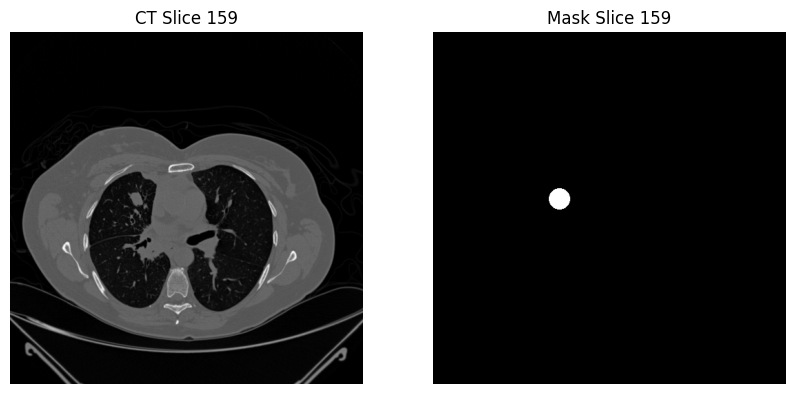

In [133]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA

def load_data(ct_scan_path, mask_path):
    """Load the CT scan and mask from .npy files."""
    ct_volume = np.load(ct_scan_path)
    mask_volume = np.load(mask_path)
    return ct_volume, mask_volume

def compute_voxel_volume(metadata):
    """
    Compute the volume of a single voxel using spacing from metadata.
    
    Expects:
      - metadata["slice_spacing"]: distance between slices in mm.
      - metadata["pixel_spacing"]: (dy, dx) in mm.
    """
    slice_spacing = metadata.get("slice_spacing", 2.5)
    pixel_spacing = metadata.get("pixel_spacing", (0.7, 0.7))
    return slice_spacing * pixel_spacing[0] * pixel_spacing[1]  # mm³

def compute_volume(voxel_count, voxel_volume):
    """Compute total volume (mm³) from voxel count and single voxel volume."""
    return voxel_count * voxel_volume

def compute_surface_area_3d(region_mask, metadata):
    """
    Compute the 3D surface area (mm²) of a nodule region by applying marching cubes
    on the smallest bounding box containing the region_mask.
    
    If the sub-mask is uniform (all 0 or all 1), returns 0.
    """
    coords = np.argwhere(region_mask > 0)
    if coords.size == 0:
        print("Warning: Region mask is empty. Surface area set to 0.")
        return 0.0
    z_min, y_min, x_min = coords.min(axis=0)
    z_max, y_max, x_max = coords.max(axis=0) + 1
    sub_mask = region_mask[z_min:z_max, y_min:y_max, x_min:x_max]
    sub_mask = (sub_mask > 0).astype(np.uint8)
    if sub_mask.min() == sub_mask.max():
        print("Warning: Sub-mask is uniform. Surface area set to 0.")
        return 0.0
    slice_spacing = metadata.get("slice_spacing", 2.5)
    pixel_spacing = metadata.get("pixel_spacing", (0.7, 0.7))
    spacing = (slice_spacing, pixel_spacing[0], pixel_spacing[1])
    try:
        verts, faces, normals, values = measure.marching_cubes(
            sub_mask, level=0.5, spacing=spacing
        )
        area = measure.mesh_surface_area(verts, faces)
    except ValueError as e:
        print(f"marching_cubes error: {e}. Surface area set to 0.")
        area = 0.0
    return area

def compute_sphericity(volume, surface_area):
    """
    Compute 3D sphericity:
      Sphericity = (π^(1/3) * (6*Volume)^(2/3)) / SurfaceArea.
    Perfect sphere yields 1; lower values indicate more irregularity.
    """
    if surface_area <= 0:
        return 0.0
    from math import pi
    numerator = (pi ** (1/3)) * ((6 * volume) ** (2/3))
    return numerator / surface_area

def compute_pca_aspect_ratio(coords):
    """
    Compute the aspect ratio (elongation) using PCA on voxel coordinates.
    Returns ratio = (largest principal axis length) / (smallest principal axis length).
    """
    if len(coords) < 2:
        return 1.0
    pca = PCA(n_components=3)
    pca.fit(coords)
    axis_lengths = np.sqrt(pca.explained_variance_)
    min_axis = np.min(axis_lengths)
    if min_axis == 0:
        return float('inf')
    return np.max(axis_lengths) / min_axis

def compute_contour_irregularity(sphericity):
    """Define contour irregularity as 1 - sphericity."""
    return 1.0 - sphericity

def extract_features_for_nodule(ct_volume, region_mask, metadata, patient_id, label_id):
    """
    Given a binary mask for a single nodule (region_mask), extract shape‐based features.
    Uses the CT scan (to compute volume from HU spacing) and the region mask.
    Returns a dictionary with features.
    """
    # Extract voxel coordinates for the region
    coords = np.argwhere(region_mask > 0)
    if coords.size == 0:
        return None
    
    # Compute volume
    voxel_vol = compute_voxel_volume(metadata)
    volume_mm3 = compute_volume(len(coords), voxel_vol)
    
    # Compute surface area (using bounding box of region)
    surface_area_mm2 = compute_surface_area_3d(region_mask, metadata)
    
    # Compute sphericity
    sphericity_val = compute_sphericity(volume_mm3, surface_area_mm2)
    
    # Compute aspect ratio via PCA
    aspect_ratio = compute_pca_aspect_ratio(coords)
    
    # Compute contour irregularity
    contour_irregularity = compute_contour_irregularity(sphericity_val)
    
    # Compute center slice (average z coordinate)
    center_slice = int(np.round(np.mean(coords[:, 0])))
    
    features = {
        "Patient ID": patient_id,
        "Nodule Label": label_id,
        "Mask Center Slice": center_slice,
        "Volume (mm^3)": volume_mm3,
        "Surface Area (mm^2)": surface_area_mm2,
        "Sphericity": sphericity_val,
        "Aspect Ratio": aspect_ratio,
        "Contour Irregularity": contour_irregularity
    }
    return features

def extract_all_nodule_features(ct_volume, mask_volume, metadata, patient_id, min_voxel_threshold=10):
    """
    Label connected components in the mask and extract features for each nodule.
    Only regions with at least min_voxel_threshold voxels are processed.
    
    Returns a list of feature dictionaries.
    """
    labeled_mask = measure.label(mask_volume > 0)
    nodule_features = []
    
    for region in regionprops(labeled_mask):
        if region.area < min_voxel_threshold:
            continue  # Skip very small regions
        # Create a binary mask for this nodule
        nodule_mask = (labeled_mask == region.label).astype(np.uint8)
        features = extract_features_for_nodule(ct_volume, nodule_mask, metadata, patient_id, region.label)
        if features is not None:
            nodule_features.append(features)
    return nodule_features

def save_features_to_csv(features_list, output_csv):
    """
    Save a list of feature dictionaries to a CSV file.
    Appends if the file exists.
    """
    df = pd.DataFrame(features_list)
    if os.path.exists(output_csv):
        df.to_csv(output_csv, mode='a', header=False, index=False)
    else:
        df.to_csv(output_csv, mode='w', header=True, index=False)
    print(f"Features saved to {output_csv}")

def display_nodule_at_slice(ct_volume, mask_volume, slice_index):
    """Display the CT scan and mask at a specified slice."""
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(ct_volume[slice_index], cmap='gray')
    plt.title(f"CT Slice {slice_index}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_volume[slice_index], cmap='gray')
    plt.title(f"Mask Slice {slice_index}")
    plt.axis('off')
    plt.show()

def main():
    # Paths (edit as needed)
    patient_id = "1546"  # Change based on scan
    ct_scan_path = f"../cache/{patient_id}_processed/ct_scan_hu.npy"
    mask_path    = f"../cache/{patient_id}_processed/isolated_ASRG_cancer.npy"
    output_csv   = "../cache/nodule_features.csv"
    
    # Metadata for spacing (mm)
    metadata = {
        "slice_spacing": 2.5,
        "pixel_spacing": (0.7, 0.7)
    }
    
    # 1. Load CT scan and mask
    ct_volume, mask_volume = load_data(ct_scan_path, mask_path)
    
    # 2. Label connected components in the mask to separate nodules
    # This will create a labeled mask where each unique region gets a unique label.
    labeled_mask = measure.label(mask_volume > 0)
    
    # 3. Extract features for each nodule region
    nodule_features = extract_all_nodule_features(ct_volume, mask_volume, metadata, patient_id)
    
    if not nodule_features:
        print("No valid nodule regions found. Exiting.")
        return
    
    # 4. Save features to CSV
    save_features_to_csv(nodule_features, output_csv)
    
    # 5. For visualization, display the CT and mask at the center slice of the first nodule
    #    (if multiple nodules exist, you can loop or select a specific one)
    first_nodule = nodule_features[0]
    center_slice = first_nodule["Mask Center Slice"]
    print(f"Displaying CT and mask at nodule center slice: {center_slice} (Nodule Label: {first_nodule['Nodule Label']})")
    display_nodule_at_slice(ct_volume, mask_volume, center_slice)

if __name__ == "__main__":
    main()

# Refined Feature Extraction

CT volume shape: (481, 512, 512)
Mask shape: (481, 512, 512)
=== Extracted Nodule Features ===
nodule_id: 1
patient_id: 1003
Volume (voxels): 2439
Volume (mm^3): 2987.7749999999996
Surface Area (mm^2): 1085.8036143534468
Sphericity: 0.9239137579000251
Aspect Ratio: 1.9366873365641772
Contour Irregularity: 0.07608624209997494
Mask Center Slice: 295
Features saved to ../cache/1003_processed/nodule_features.csv
Displaying CT and mask at slice 295 for nodule 1


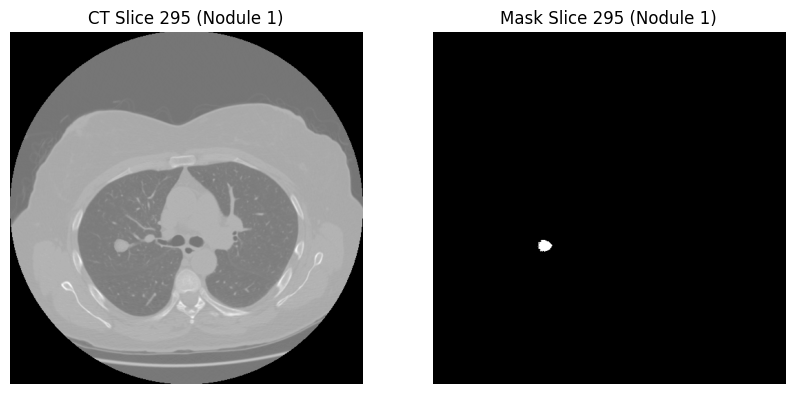

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from sklearn.decomposition import PCA

# ---------------------------
# Spacing metadata (in mm)
# ---------------------------
METADATA = {
    "slice_spacing": 2.5,        # distance between slices in mm
    "pixel_spacing": (0.7, 0.7)    # (dy, dx) in mm
}

# ---------------------------
# Feature Computation Functions
# ---------------------------
def load_data(ct_scan_path, mask_path):
    """Load the CT scan and mask from .npy files."""
    ct_volume = np.load(ct_scan_path)
    mask_volume = np.load(mask_path)
    return ct_volume, mask_volume

def extract_voxel_coords_from_mask(mask_volume):
    """
    Extract the (z, y, x) coordinates for all voxels where the mask is nonzero.
    
    Returns:
        coords (np.array): An N x 3 array.
    """
    return np.argwhere(mask_volume > 0)

def compute_voxel_volume(metadata):
    """Compute the volume (in mm³) of one voxel."""
    dz = metadata.get("slice_spacing", 2.5)
    dy, dx = metadata.get("pixel_spacing", (0.7, 0.7))
    return dz * dy * dx

def compute_volume(voxel_count, voxel_volume):
    """Compute total volume (mm³) from voxel count."""
    return voxel_count * voxel_volume

def compute_surface_area_3d(mask_volume, metadata):
    """
    Compute the 3D surface area (mm²) of the nodule by running marching cubes
    on the smallest bounding box containing the mask.
    
    Returns 0 if the sub-mask is uniform.
    """
    coords = np.argwhere(mask_volume > 0)
    if coords.size == 0:
        print("Warning: Mask is empty. Surface area set to 0.")
        return 0.0
    # Define bounding box
    z_min, y_min, x_min = coords.min(axis=0)
    z_max, y_max, x_max = coords.max(axis=0) + 1  # inclusive
    sub_mask = mask_volume[z_min:z_max, y_min:y_max, x_min:x_max]
    sub_mask = (sub_mask > 0).astype(np.uint8)
    if sub_mask.min() == sub_mask.max():
        print("Warning: Sub-mask is uniform. Surface area set to 0.")
        return 0.0
    dz = metadata.get("slice_spacing", 2.5)
    dy, dx = metadata.get("pixel_spacing", (0.7, 0.7))
    spacing = (dz, dy, dx)  # (dz, dy, dx)
    try:
        verts, faces, normals, values = measure.marching_cubes(sub_mask, level=0.5, spacing=spacing)
        area = measure.mesh_surface_area(verts, faces)
    except ValueError as e:
        print(f"marching_cubes error: {e}. Surface area set to 0.")
        area = 0.0
    return area

def compute_sphericity(volume, surface_area):
    """
    Compute sphericity:
      Sphericity = (π^(1/3) * (6 * Volume)^(2/3)) / SurfaceArea.
    A perfect sphere has sphericity = 1.
    """
    if surface_area <= 0:
        return 0.0
    from math import pi
    numerator = (pi ** (1/3)) * ((6 * volume) ** (2/3))
    return numerator / surface_area

def compute_pca_aspect_ratio(coords):
    """
    Compute the aspect ratio (elongation) using PCA on voxel coordinates.
    Returns the ratio of the largest to smallest principal axis lengths.
    """
    if len(coords) < 2:
        return 1.0
    pca = PCA(n_components=3)
    pca.fit(coords)
    axis_lengths = np.sqrt(pca.explained_variance_)
    min_axis = np.min(axis_lengths)
    if min_axis == 0:
        return float('inf')
    return np.max(axis_lengths) / min_axis

def compute_contour_irregularity(sphericity):
    """Define contour irregularity as 1 - sphericity."""
    return 1.0 - sphericity

# ---------------------------
# Feature Extraction and CSV Saving
# ---------------------------
def extract_features(ct_volume, mask_volume, metadata, patient_id):
    """
    Directly extract features from the given mask (assumed to have only one nodule).
    
    Returns a dictionary with the extracted features.
    """
    # Use the entire mask as the nodule
    coords = extract_voxel_coords_from_mask(mask_volume)
    if coords.size == 0:
        print("No nodule voxels found in mask. Exiting.")
        return None
    voxel_count = coords.shape[0]
    voxel_vol = compute_voxel_volume(metadata)
    volume_mm3 = compute_volume(voxel_count, voxel_vol)
    surface_area_mm2 = compute_surface_area_3d(mask_volume, metadata)
    sph = compute_sphericity(volume_mm3, surface_area_mm2)
    aspect_ratio = compute_pca_aspect_ratio(coords)
    contour_irreg = compute_contour_irregularity(sph)
    center_slice = int(np.round(np.mean(coords[:, 0])))
    
    features = {
        "nodule_id": 1,
        "patient_id": patient_id,
        "Volume (voxels)": voxel_count,
        "Volume (mm^3)": volume_mm3,
        "Surface Area (mm^2)": surface_area_mm2,
        "Sphericity": sph,
        "Aspect Ratio": aspect_ratio,
        "Contour Irregularity": contour_irreg,
        "Mask Center Slice": center_slice
    }
    return features

def save_features_to_csv(features, output_csv):
    """
    Save extracted features to a CSV file. Appends if file exists.
    """
    df = pd.DataFrame([features])
    if os.path.exists(output_csv):
        df.to_csv(output_csv, mode='a', header=False, index=False)
    else:
        df.to_csv(output_csv, mode='w', header=True, index=False)
    print(f"Features saved to {output_csv}")

def display_nodule_at_slice(ct_volume, mask_volume, slice_index, nodule_id=None):
    """Display the CT slice and the mask slice at the given index."""
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(ct_volume[slice_index], cmap='gray')
    title = f"CT Slice {slice_index}"
    if nodule_id is not None:
        title += f" (Nodule {nodule_id})"
    plt.title(title)
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(mask_volume[slice_index], cmap='gray')
    title = f"Mask Slice {slice_index}"
    if nodule_id is not None:
        title += f" (Nodule {nodule_id})"
    plt.title(title)
    plt.axis('off')
    plt.show()

def main():
    # Paths (edit as needed)
    patient_id = "1003"
    ct_scan_path = f"../cache/{patient_id}_processed/ct_scan_hu.npy"
    mask_path = f"../cache/{patient_id}_processed/isolated_ASRG_cancer.npy"
    output_csv = f"../cache/{patient_id}_processed/nodule_features.csv"
    
    # 1. Load full CT volume and mask
    ct_volume, mask_volume = load_data(ct_scan_path, mask_path)
    print(f"CT volume shape: {ct_volume.shape}")
    print(f"Mask shape: {mask_volume.shape}")
    
    # 2. Extract features from the mask
    features = extract_features(ct_volume, mask_volume, METADATA, patient_id)
    if features is None:
        return
    
    # 3. Display extracted features
    print("=== Extracted Nodule Features ===")
    for key, val in features.items():
        print(f"{key}: {val}")
    
    # 4. Save features to CSV
    save_features_to_csv(features, output_csv)
    
    # 5. Display CT and mask at the mask center slice
    center_slice = features["Mask Center Slice"]
    print(f"Displaying CT and mask at slice {center_slice} for nodule {features['nodule_id']}")
    display_nodule_at_slice(ct_volume, mask_volume, center_slice, nodule_id=features["nodule_id"])

if __name__ == "__main__":
    main()
